# Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самыми высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv, geo_data_2.csv. 
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# План работы
[Этап 1. Предобработка](#1)  
[Этап 2. Обучение и проверка модели](#2)  
[Этап 3. Подготовка к расчёту прибыли](#3)  
[Этап 4. Расчёт прибыли и рисков](#4) 

### Импорт библиотек

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np

import os
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(5,4)})

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Функции

поиск и загрузка файла

In [2]:
def get_file(file_name, url):
    if not os.path.exists(file_name):
        print('Файл не найден и будет загружен из сети.')
        file_name, headers = urlretrieve(url)
    return pd.read_csv(file_name)

# 1. Предобработка

Поместим три датасета в словарь для более удобного доступа к ним

In [3]:
d = {}
for i in range(3):
    # open dataset and saving in dictionary
    file_name = f'geo_data_{i}.csv'
    url = f'/datasets/geo_data_{i}.csv'
    d[f'region_{i}'] = get_file(file_name, url)
    
    # dataset info
    print(f'Region_{i}')
    display(d[f'region_{i}'].info())
    display(d[f'region_{i}'].head())

Region_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Region_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Region_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Пропусков в данных не обнаружили проверим на дубликаты

In [4]:
for i in range(3):
    print(d[f'region_{i}'].duplicated().sum())

0
0
0


Удалим id, так как он не влияет на целевую переменную

In [5]:
for i in range(3):
    d[f'region_{i}'] = d[f'region_{i}'].drop('id', axis=1)

Преобразуем тип данных для оптимизации памяти

In [6]:
for i in range(3):
    for j in list(d['region_0'].columns):
        d[f'region_{i}'][j] = pd.to_numeric(d[f'region_{i}'][j], downcast='float')

### Анализ мультиколлинеарности

Correlation matrix for Region 0


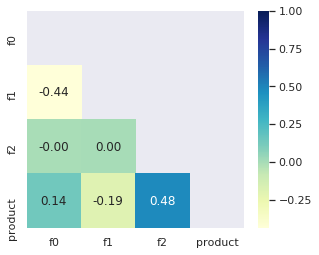

Correlation matrix for Region 1


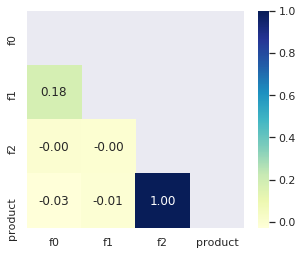

Correlation matrix for Region 2


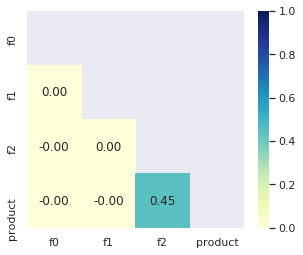

In [7]:
for i in range(3):
    print(f'Correlation matrix for Region {i}')
    sns.heatmap(d[f'region_{i}'].corr(), annot=True, fmt='0.2f', cmap='YlGnBu', 
                mask=np.triu(d[f'region_{i}'].corr()), square=True)
    plt.show()

Region 0


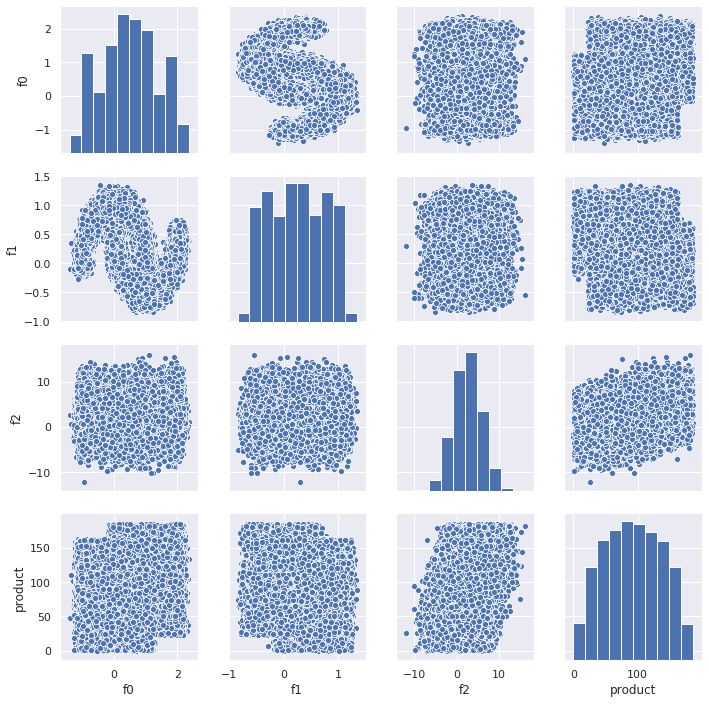

Region 1


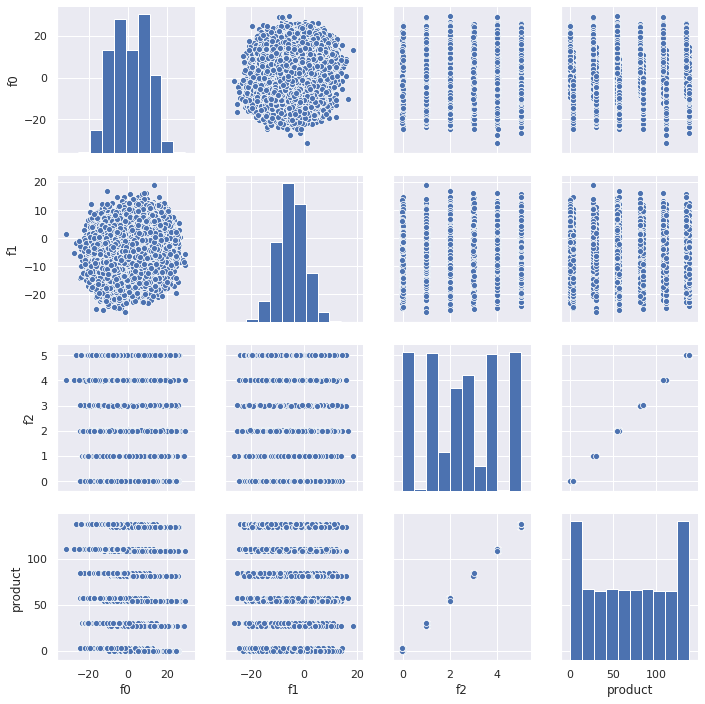

Region 2


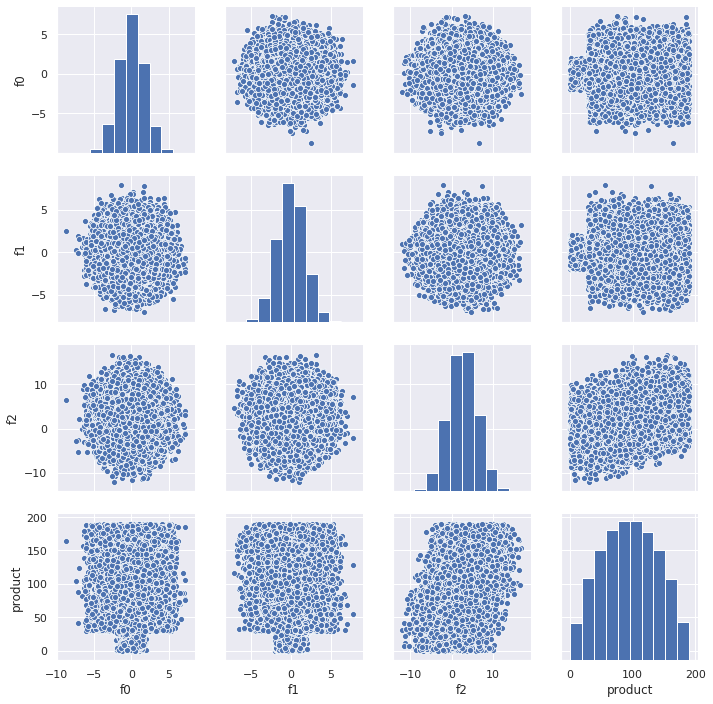

In [8]:
for i in range(3):
    print(f'Region {i}')
    sns.pairplot(d[f'region_{i}'])
    plt.show()

### Выводы
- Признаки в каждом датасете имеют разную природу, это видно из их распределений. Поэтому мы не можем объединить эти датасеты, и для каждого нужна своя модель
- Наблюдается сильная линейная зависимость признака f2 с целевой переменной. 
- В регионе1 смущает сильная зависимость меджду признаком f2 и целевым. В регионе1 кажется модель совсем не требуется и можно делать предсказания только опираясь на признак f2.

<a id='2'></a>
# 2. Обучение и проверка модели

Разобьем данные на обучающую и валидационную выборки в соотношении 3 : 1

In [9]:
RS = 333

for i in range(3):
    features = d[f'region_{i}'].drop('product', axis=1)
    target = d[f'region_{i}']['product']
    
    d[f'features_train_{i}'], d[f'features_valid_{i}'], d[f'target_train_{i}'], d[f'target_valid_{i}'] = (
        train_test_split(features, target, test_size=0.25, random_state=RS)
    )

Проверим как резделлились данные

In [10]:
for i in d:
    print('{:<20}{:>5}{:}'.format(i+':', 'shape', d[i].shape))

region_0:           shape(100000, 4)
region_1:           shape(100000, 4)
region_2:           shape(100000, 4)
features_train_0:   shape(75000, 3)
features_valid_0:   shape(25000, 3)
target_train_0:     shape(75000,)
target_valid_0:     shape(25000,)
features_train_1:   shape(75000, 3)
features_valid_1:   shape(25000, 3)
target_train_1:     shape(75000,)
target_valid_1:     shape(25000,)
features_train_2:   shape(75000, 3)
features_valid_2:   shape(25000, 3)
target_train_2:     shape(75000,)
target_valid_2:     shape(25000,)


Обучим модель линейной регрессии, сохраним предсказания в словаре `d['prediction']`, правильные ответы уже сохранены в `d['target_valid']`. Построим график отношения предсказаний и правильных ответов для каждого региона

График отношения предсказаний к реальным ответам, регион 0


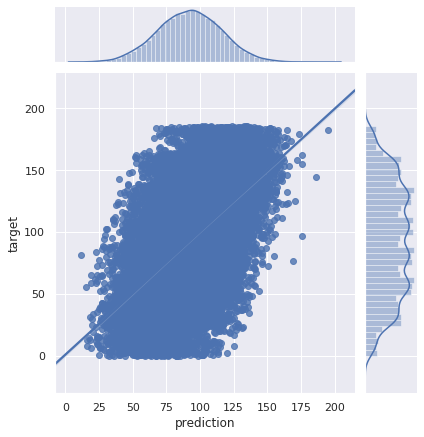

График отношения предсказаний к реальным ответам, регион 1


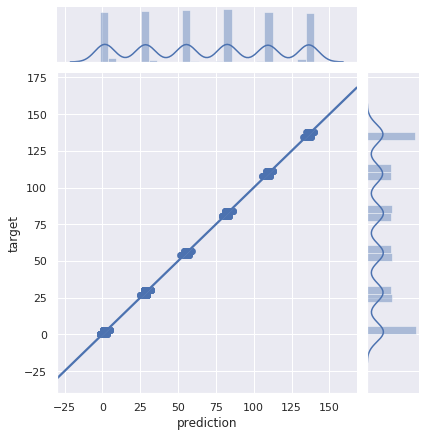

График отношения предсказаний к реальным ответам, регион 2


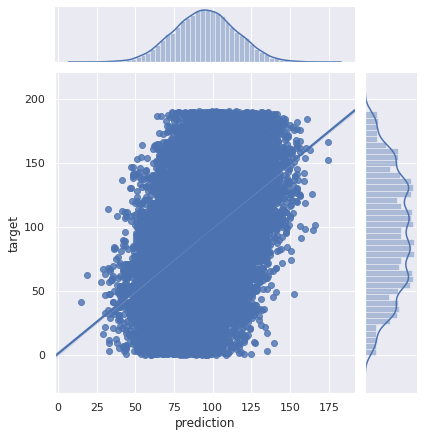

In [11]:
results = {
    'mean': [],
    'rmse': []
}

model = LinearRegression()
for i in range(3):
    # train model
    model.fit(d[f'features_train_{i}'], d[f'target_train_{i}'])
    prediction = pd.Series(model.predict(d[f'features_valid_{i}']), index = d[f'target_valid_{i}'].index)
    # add predictions to the main dictionary
    d[f'prediction_{i}'] = prediction
    
    # add mean and rmse to the results dictionary
    results['mean'].append(prediction.mean())
    results['rmse'].append(mean_squared_error(d[f'target_valid_{i}'], prediction)**0.5)
    
    # graphics
    print(f'График отношения предсказаний к реальным ответам, регион {i}')
    sns.jointplot(x=prediction, y=d[f'target_valid_{i}'], kind='reg')
    plt.xlabel('prediction') 
    plt.ylabel('target')
    plt.show()

Выведем результаты предсказаний среднего запаса и среднеквадратичной ошибки по трем моделям в таблице

In [12]:
pd.DataFrame(results)

,mean,rmse
0,92.254143,37.596878
1,68.468773,0.884795
2,95.123520,39.844213


### Выводы:
По графикам выше видно, что отношение предсказаий к правильным ответам повторяют отношения между признаком f2 и целевым признаком.

В регионе0 и регионе2 модели предсказывают больший объем запасов, но ошибка таких предсказаний выше. В регионе1 среднеквадратичная ошибка меньше , но и средений предсказанный запас тоже меньше. Помним что в регионе1 сильная линейная зависимость между признаком f2 и целевым признаком, отсюда и хорошее качество модели.

Посчитаем возможную прибыль и риски для каждого региона.

<a id='3'></a>
# 3. Подготовка к расчёту прибыли

### Условия задачи, константы

- При разведке региона исследуют 500 точек wells, из которых выбирают 200 лучших top_wells для расчёта прибыли.
- Бюджет на разработку скважин в регионе total_budget — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода profit_per_barrel. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей profit_per_product.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5% risk_threshold. Среди них выбирают регион с наибольшей средней прибылью.

In [13]:
WELLS = 500
TOP_WELLS = 200
TOTAL_BUDGET = 10e9
PROFIT_PER_BARREL = 450
PROFIT_PER_PRODUCT = PROFIT_PER_BARREL * 1000

RISK_THRESHOLD = 0.025

Рассчитаем минимальный объём сырья для безубыточной разработки новой скважины (тыс. баррелей)

In [14]:
MIN_VOLUME = (TOTAL_BUDGET / 200) / PROFIT_PER_PRODUCT
print('{:.2f} тыс. баррелей'.format(MIN_VOLUME))

111.11 тыс. баррелей


Посмотрим на средний запас скважины в каждом регионе (тыс. баррелей):

In [15]:
for i in range(3):
    print('средний запас скважины в регионе {}: {:.0f} тыс. баррелей'.format(i, d[f'region_{i}']['product'].mean()))

средний запас скважины в регионе 0: 92 тыс. баррелей
средний запас скважины в регионе 1: 69 тыс. баррелей
средний запас скважины в регионе 2: 95 тыс. баррелей


### Выводы:
Необходимый минимальный объем сырья для окупаемости разработки скважин - 111 тыс. баррелей, что больше, чем средний запас всех скважин в любом из этих трех регионов. Поэтому надо внимательно отнестись к выбору скважин для разработки.

### Функция для расчета прибыли

In [16]:
def gross_mln(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target.loc[probs_sorted.index][:count]
    return (selected.sum() * PROFIT_PER_PRODUCT - TOTAL_BUDGET) / 10e5

<a id='4'></a>
# 4. Расчёт прибыли и рисков 

Найдем распределение средней прибыли с помощью техники Bootstrap и сохраним в переменной `values`

In [17]:
samples = 1000
state = np.random.RandomState(12345)

values = []
for i in range(3):
    l=[]
    for _ in range(samples):
        pred_subsample = d[f'prediction_{i}'].sample(n=WELLS, replace=True,
                                              random_state=state)
        target_subsample = d[f'target_valid_{i}'].loc[pred_subsample.index]
        l.append(gross_mln(target_subsample, pred_subsample, TOP_WELLS))
    values.append(pd.Series(l))

print(len(values))

3


Сделаем словарь с результатами для каждого региона, где:
- gross_profit - средняя прибыль, млн руб.
- lower - нижняя граница 95% доверительного интервала
- upper - верхняя граница 95% доверительного интервала
- risk, % - вероятность убытков (то есть сколько раз из тысячи мы можем понести убытки)

In [18]:
results = {
    'gross_profit':[],
    'lower':[],
    'upper':[],
    'risk, %':[]
}

for i in range(3):
    results['gross_profit'].append(round(values[i].mean(), 2))
    results['lower'].append(round(values[i].quantile(0.025), 2))
    results['upper'].append(round(values[i].quantile(0.975), 2))
    results['risk, %'].append(round(values[i][values[i] < 0].count() / samples * 100, 2))
#    results['risk, %'].append(round(values[i][values[i] < 0].count() / samples * 100, 2))

pd.DataFrame(results)

,gross_profit,lower,upper,"risk, %"
0,426.08,-140.32,916.56,6.7
1,474.33,77.29,925.78,1.2
2,391.15,-163.12,937.73,9.5


Для наглядность построим график распределения прибыли и отметим границы 95% доверительного интервала

                       График bootstrap распределения прибыли                        


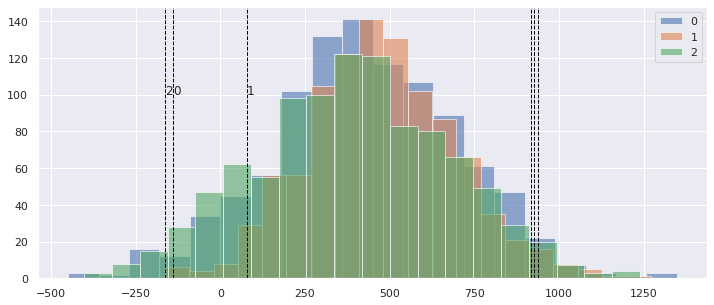

In [19]:
sns.set(rc={'figure.figsize':(12,5)})
print('{:^85}'.format('График bootstrap распределения прибыли'))

# distribution
for i in range(3):
    ax = plt.gca()
    ax.hist(values[i], bins=20, alpha=0.6)
    ax.legend([0, 1, 2])

# quantiles
for i in range(3):
    plt.axvline(values[i].quantile(RISK_THRESHOLD), color='black', 
                linewidth='1', linestyle='dashed', label='confidental_interval')
    plt.axvline(values[i].quantile(1 - RISK_THRESHOLD), color='black', 
                linewidth='1', linestyle='dashed')
    ax.text(values[i].quantile(RISK_THRESHOLD), 100, i)

Построим график распределения 2.5% квантиля прибыли/убытков для каждого региона

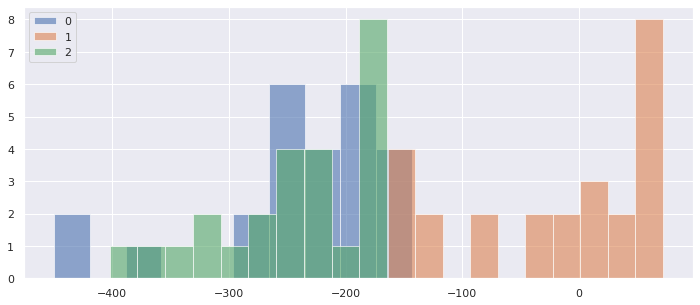

In [21]:
for i in range(3):
    risk_threshold_distr = []
    for j in values[i]:
        if j < values[i].quantile(RISK_THRESHOLD):
            risk_threshold_distr.append(j)
    ax =plt.gca()
    ax.hist(pd.Series(risk_threshold_distr), alpha=0.6)
    ax.legend([0,1,2])

### Выводы:
- Наибольшая ожидаемая средняя прибыль в регионе1 - 474.33 млн. руб;
- В 95%-й доверительный интервал региона1 не попали убыточные средние, то есть с вероятностью 95% разработка в этом регионе будет безубыточной;
- Наименьший риск убытков в регионе1 - 1.2%

На основании вышеизложенных наблюдений можно рекомендовать регион1 для разарботки скважин.